In [3]:
import src.lsh_scratch as lsh
import pandas as pd
import numpy as np
import time
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn.neighbors import KNeighborsTransformer
import matplotlib.pyplot as plt

In [4]:
##############################################################
# Parameters
##############################################################
leaf_size = 40
n_data = 10000

In [5]:
##############################################################
# Data
##############################################################
data = pd.read_csv('dataset/mnist_train.csv')
data = data.values
data_algorithm = data[:n_data, 1:]

In [6]:
##############################################################
# utils
##############################################################
def recall(true, pred):
    return len(set(true).intersection(set(pred))) / len(true)

In [7]:
##############################################################
# Brute Force
##############################################################
nn = NearestNeighbors(algorithm='brute')
nn_start = time.time()
nn.fit(data_algorithm)
nn_end = time.time()
nn_time = nn_end - nn_start
# print("NN time: ", nn_time)
nn_indices = nn.kneighbors(data_algorithm[0].reshape(1, -1), n_neighbors=10, return_distance=False)
# print("NN recall: ", recall(nn_indices[0], nn_indices[0]))

In [8]:
##############################################################
# KDTree
##############################################################
kd_start = time.time()
kd_tree = KDTree(data_algorithm, leaf_size=leaf_size)
kd_end = time.time()
kd_time = kd_end - kd_start
print("KDTree time: ", kd_time)
kd_indices = kd_tree.query(data_algorithm[0].reshape(1, -1), k=10, return_distance=False)
print("KDTree recall: ", recall(nn_indices[0], kd_indices[0]))

KDTree time:  0.9162428379058838
KDTree recall:  1.0


In [9]:
##############################################################
# BallTree
##############################################################
ball_start = time.time()
ball_tree = BallTree(data_algorithm, leaf_size=leaf_size)
ball_end = time.time()
ball_time = ball_end - ball_start
print("BallTree time: ", ball_time)
ball_indices = ball_tree.query(data_algorithm[0].reshape(1, -1), k=10, return_distance=False)
print("BallTree recall: ", recall(nn_indices[0], ball_indices[0]))

BallTree time:  0.6422886848449707
BallTree recall:  1.0


In [10]:
##############################################################
# LSH
##############################################################
data_algorithm_lsh = data_algorithm.astype('float64') / 255
lsh = lsh.LSH(random_state=5, n_estimators=10, n_candidates=1000)
lsh_start = time.time()
lsh.fit(data_algorithm_lsh)
lsh_end = time.time()
lsh_time = lsh_end - lsh_start
print("LSH time: ", lsh_time)
lsh_distances, lsh_indices = lsh.kneighbors(data_algorithm_lsh[0].reshape(1, -1), n_neighbors=10)
print("LSH recall: ", recall(nn_indices[0], lsh_indices[0]))

LSH time:  0.001512765884399414
LSH recall:  0.1


In [13]:
##############################################################
# Feature Hashing
##############################################################
def _histogram(data, bins=10, _range=None):
    # Determine the range of the data
    if _range is None:
        data_min = min(data)
        data_max = max(data)
    else:
        data_min, data_max = _range
    # Determine the bin size
    bin_size = (data_max - data_min) / bins
    # Initialize the histogram
    hist = [0] * bins
    # Count the number of data points in each bin
    for value in data:
        bin_index = int((value - data_min) / bin_size)
        if bin_index == bins:
            bin_index -= 1
        hist[bin_index] += 1
    # Compute the bin edges
    # bin_edges = [(data_min + i * bin_size) for i in range(bins + 1)]
    bin_edges = []
    for i in range(bins + 1):
        bin_edges.append(data_min + i * bin_size)
    return hist, bin_edges

def feature_hashing(data, n_bins=50, _range=None):
    # print(data.shape)
    # print(type(data[0]))
    if _range is None:
        _range = [min(data), max(data)]
        data_min = min(data)
        data_max = max(data)
    else:
        data_min, data_max = _range
    bin_size = (data_max - data_min) / n_bins
    hash_data = np.zeros((data.shape[0], n_bins))
    for i in range(data.shape[0]):
        hist, _ = np.histogram(data[i], bins=n_bins, range=_range)
        hash_data[i] = hist
    return hash_data


In [15]:
data_algorithm_hash50 = feature_hashing(data_algorithm, n_bins=50, _range=(0, 255))

In [16]:
data_algorithm_hash100 = feature_hashing(data_algorithm, n_bins=100, _range=(0, 255))
print(data_algorithm_hash100.shape)
data_algorithm_hash150 = feature_hashing(data_algorithm, n_bins=150, _range=(0, 255))
print(data_algorithm_hash150.shape)
data_algorithm_hash200 = feature_hashing(data_algorithm, n_bins=200, _range=(0, 255))
print(data_algorithm_hash200.shape)
data_algorithm_hash250 = feature_hashing(data_algorithm, n_bins=250, _range=(0, 255))
print(data_algorithm_hash250.shape)

(10000, 100)
(10000, 150)
(10000, 200)
(10000, 250)


In [17]:
data_algorithm_hash40 = feature_hashing(data_algorithm, n_bins=40, _range=(0, 255))
data_algorithm_hash30 = feature_hashing(data_algorithm, n_bins=30, _range=(0, 255))
data_algorithm_hash20 = feature_hashing(data_algorithm, n_bins=20, _range=(0, 255))
data_algorithm_hash10 = feature_hashing(data_algorithm, n_bins=10, _range=(0, 255))

In [20]:
data_algorithm_hash = [data_algorithm_hash10, data_algorithm_hash20, data_algorithm_hash30, data_algorithm_hash40, 
                       data_algorithm_hash50, data_algorithm_hash100, data_algorithm_hash150, data_algorithm_hash200, 
                       data_algorithm_hash250]

hash_nn = NearestNeighbors(algorithm='brute')
hash_nn_start = time.time()
hash_nn.fit(data_algorithm_hash[0])
hash_nn_end = time.time()
hash_nn_time = hash_nn_end - hash_nn_start
print("Hash NN time: ", hash_nn_time)
hash_nn_indices = hash_nn.kneighbors(data_algorithm_hash[0][0].reshape(1, -1), n_neighbors=10, return_distance=False)
print("Hash NN recall: ", recall(hash_nn_indices[0], hash_nn_indices[0]))

hash_times_kd = []
hash_times_ball = []

for i in range(len(data_algorithm_hash)):
    hash_kd_start = time.time()
    hash_kd_tree = KDTree(data_algorithm_hash[i], leaf_size=leaf_size)
    hash_kd_end = time.time()
    hash_kd_time = hash_kd_end - hash_kd_start
    # print("Hash KDTree time: ", hash_kd_time)
    # hash_kd_indices = hash_kd_tree.query(data_algorithm_hash[0][0].reshape(1, -1), k=10, return_distance=False)
    # print("Hash KDTree recall: ", recall(hash_nn_indices[0], hash_kd_indices[0]))
    hash_times_kd.append(hash_kd_time)

for i in range(len(data_algorithm_hash)):
    hash_ball_start = time.time()
    hash_ball_tree = BallTree(data_algorithm_hash[i], leaf_size=leaf_size)
    hash_ball_end = time.time()
    hash_ball_time = hash_ball_end - hash_ball_start
    # print("Hash BallTree time: ", hash_ball_time)
    # hash_ball_indices = hash_ball_tree.query(data_algorithm_hash[0][0].reshape(1, -1), k=10, return_distance=False)
    # print("Hash BallTree recall: ", recall(hash_nn_indices[0], hash_ball_indices[0]))
    hash_times_ball.append(hash_ball_time)

Hash NN time:  0.0
Hash NN recall:  1.0


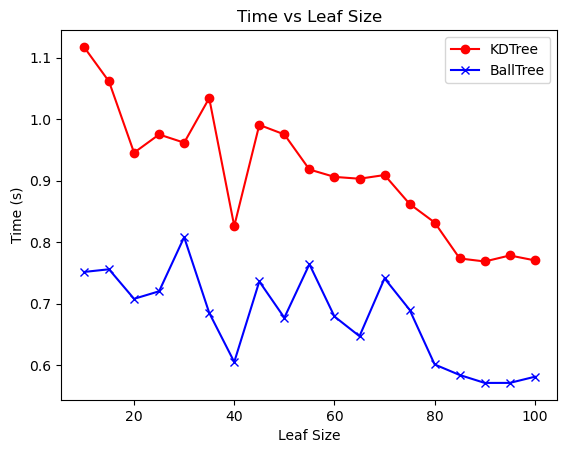

In [23]:
##############################################################
# Test Leaf Size
##############################################################
leaf_sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
KDTree_times = []
BallTree_times = []
for leaf_size in leaf_sizes:
    kd_start = time.time()
    kd_tree = KDTree(data_algorithm, leaf_size=leaf_size)
    kd_end = time.time()
    kd_time = kd_end - kd_start
    KDTree_times.append(kd_time)
    ball_start = time.time()
    ball_tree = BallTree(data_algorithm, leaf_size=leaf_size)
    ball_end = time.time()
    ball_time = ball_end - ball_start
    BallTree_times.append(ball_time)
# Plot the results
plt.plot(leaf_sizes, KDTree_times, label='KDTree', color='red', marker='o')
plt.plot(leaf_sizes, BallTree_times, label='BallTree', color='blue', marker='x')
plt.legend()
plt.xlabel('Leaf Size')
plt.ylabel('Time (s)')
plt.title('Time vs Leaf Size')
plt.show()

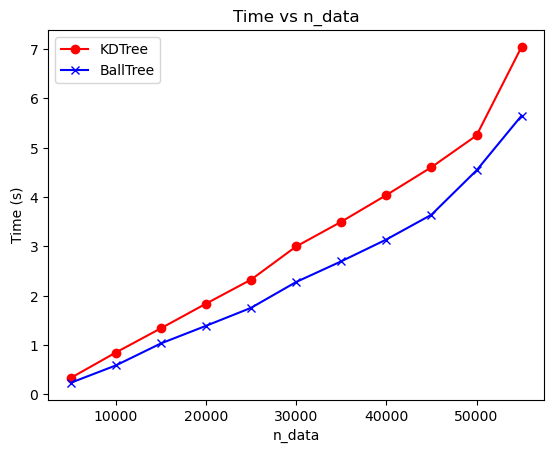

In [24]:
##############################################################
# Test n_data
##############################################################
n_datas = []
for i in range(1, 12):
    n_datas.append(i * 5000)
KDTree_times = []
BallTree_times = []
for n_data in n_datas:
    data_algorithm = data[:n_data, 1:]
    kd_start = time.time()
    kd_tree = KDTree(data_algorithm, leaf_size=leaf_size)
    kd_end = time.time()
    kd_time = kd_end - kd_start
    KDTree_times.append(kd_time)
    ball_start = time.time()
    ball_tree = BallTree(data_algorithm, leaf_size=leaf_size)
    ball_end = time.time()
    ball_time = ball_end - ball_start
    BallTree_times.append(ball_time)
# Plot the results
plt.plot(n_datas, KDTree_times, label='KDTree', color='red', marker='o')
plt.plot(n_datas, BallTree_times, label='BallTree', color='blue', marker='x')
plt.legend()
plt.xlabel('n_data')
plt.ylabel('Time (s)')
plt.title('Time vs n_data')
plt.show()

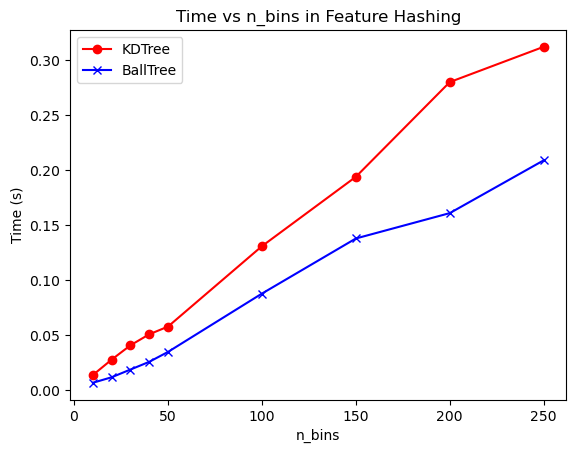

In [25]:
# Plot hash times
n_bins = [10, 20, 30, 40, 50, 100, 150, 200, 250]
plt.plot(n_bins, hash_times_kd, label='KDTree', color='red', marker='o')
plt.plot(n_bins, hash_times_ball, label='BallTree', color='blue', marker='x')
plt.legend()
plt.xlabel('n_bins')
plt.ylabel('Time (s)')
plt.title('Time vs n_bins in Feature Hashing')
plt.show()

In [28]:
# Calculate performance of kd_tree and ball_tree under different n_bins
n_bins = [10, 20, 30, 40, 50, 100, 150, 200, 250]
kd_times = []
ball_times = []
for i in range(len(n_bins)):
    kd_start = time.time()
    kd_tree = KDTree(data_algorithm_hash[i], leaf_size=10)
    kd_end = time.time()
    kd_time = kd_end - kd_start
    kd_times.append(kd_time)
    ball_start = time.time()
    ball_tree = BallTree(data_algorithm_hash[i], leaf_size=10)
    ball_end = time.time()
    ball_time = ball_end - ball_start
    ball_times.append(ball_time)

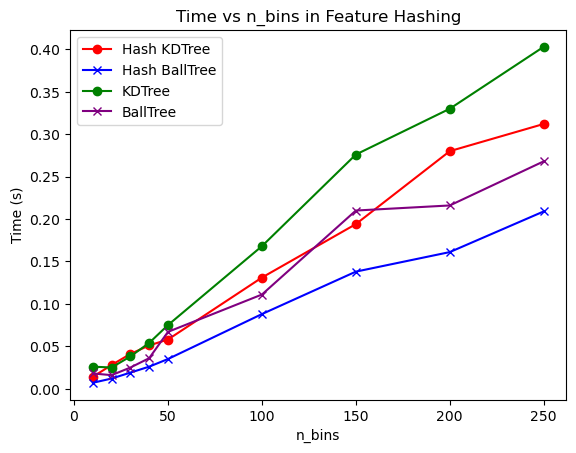

In [32]:
# Plot comparison of normal and hash
plt.plot(n_bins, hash_times_kd, label='Hash KDTree', color='red', marker='o')
plt.plot(n_bins, hash_times_ball, label='Hash BallTree', color='blue', marker='x')
plt.plot(n_bins, kd_times, label='KDTree', color='green', marker='o')
plt.plot(n_bins, ball_times, label='BallTree', color='purple', marker='x')
plt.legend()
plt.xlabel('n_bins')
plt.ylabel('Time (s)')
plt.title('Time vs n_bins in Feature Hashing')
plt.show()